<a href="https://colab.research.google.com/github/4en1x/diploma/blob/master/Final7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cd /usr/src
!ln -sfn linux-headers-2.6.35-28-generic linux

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-wdpr0o04
  Stored in directory: /tmp/pip-ephem-wheel-cache-kajk1x8s/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [12]:
%%cu
#include <cuda_runtime.h>
#include "device_launch_parameters.h"
#include <stdlib.h>
#include <stdio.h>
#include <float.h>
#include "linux/kernel.h"
#include <iostream>
#include <ctime>
#include <iomanip>
#include <fstream>
#include <math.h>
#include <cmath>

using namespace std;

#define ITERATIONS 100000000
#define N 256

#define e 2.7182818

#define blockZSize 2


#define extN (N + 2)
#define Dx 1
#define h ((float) Dx / (N + 1))
#define h2 powf(h, 2.0)


float f(int i, int j) {
	return 2 * powf(e, i * h + j * h);
}

float u_t(float x) {
	return powf(e, x);
}

float u_l(float x) {
	return powf(e, x);
}

float u_r(float x) {
	return powf(e, x + 1);
}

float u_d(float x) {
	return powf(e, x + 1);
}



float func(int i, int j) {
	return powf(e, i * h + j * h);
}

float* createMatrix(int row, int col) {
	float* matrix = new float[row * col];

	for(int i = 0; i < row; i++) {
		for(int j = 0; j < col; j++) {
			matrix[i * row + j] = 0;
		}
	}

  for(int i = 0; i < row; i++) {
      matrix[0 * row + i] = u_t((i) * h);
      matrix[(row - 1) * row + i] = u_d((i) * h);
  }

  for(int j = 0; j < col; j++) {
      matrix[j * col + 0] = u_l((j) * h);
      matrix[j * col + row - 1] = u_r((j) * h);
	}
    
	return matrix;
}

float calculateDifference(float* matrix1) {
	float tolerance = 0.0f;

  for (int i = 1; i < extN - 1; i++) {
		for (int j = 1; j < extN - 1; j++) {
      float fCurrent = func(i, j);
      if(abs(matrix1[i * extN + j] - fCurrent) > tolerance) {
          tolerance = abs(matrix1[i * extN + j] - fCurrent);
      } 
		}
	}

	return tolerance;
}

int main() {

	float* matrixHost = createMatrix(extN, extN);

	long startTime = clock();

	for (size_t i = 0; i < ITERATIONS; i++) {
		for (int i = 1; i < extN - 1; i++) {
		  for (int j = 1; j < extN - 1; j += 1) {
        int b = extN * i + j;
         matrixHost[b] = 0.25 * (
                matrixHost[b + extN]
              + matrixHost[b - extN]
              + matrixHost[b + 1]
              + matrixHost[b - 1] 
              - h2 * f(i, j)
            );
		  }
	  }
      


    if(i%100 == 0) {
        float diff = calculateDifference(matrixHost);
        if(diff < 0.01) break;
        cout << diff << " ";
    }  
	}
  
	std::cout << "Calculation take time: " << clock() - startTime << std::endl;

  cout << " Difference: " << calculateDifference(matrixHost);

 
	return 0;
}

'7.27505 5.98953 5.53604 5.2255 4.98414 4.785 4.61546 4.46702 4.33514 4.21619 4.10775 4.00857 3.91658 3.83138 3.75166 3.67686 3.60643 3.53991 3.47685 3.41686 3.35958 3.30501 3.25258 3.20214 3.15358 3.10659 3.06102 3.01685 2.97376 2.93168 2.89053 2.8503 2.8108 2.77197 2.73376 2.69614 2.6591 2.62254 2.58642 2.5507 2.51549 2.48069 2.4462 2.41221 2.37855 2.34526 2.31238 2.27982 2.24768 2.21586 2.18443 2.15338 2.12262 2.09233 2.06232 2.03271 2.00349 1.97455 1.94604 1.91789 1.89005 1.86259 1.83552 1.80877 1.78233 1.75633 1.73066 1.7053 1.68026 1.65563 1.63133 1.60734 1.58367 1.56033 1.53737 1.51471 1.49236 1.47031 1.44857 1.42718 1.4061 1.38531 1.36481 1.34459 1.32466 1.30505 1.28574 1.26669 1.24792 1.22942 1.21117 1.1932 1.1755 1.15808 1.1409 1.12398 1.1073 1.09087 1.07467 1.05871 1.04298 1.0275 1.01226 0.997241 0.982441 0.967858 0.953488 0.93933 0.925379 0.911634 0.898091 0.884748 0.871611 0.858678 0.845935 0.83338 0.82101 0.808823 0.796815 0.784986 0.77333 0.761847 0.750535 0.739388 0.728

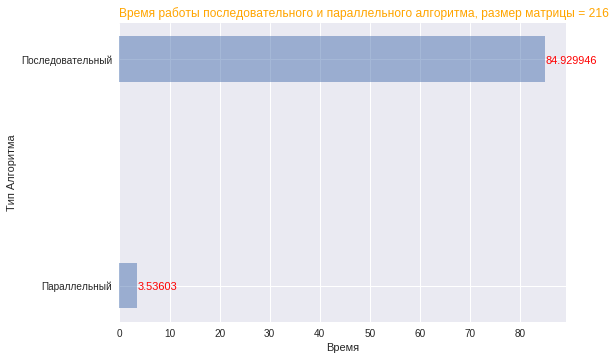

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

objects = (
    'Параллельный',
    'Последовательный',
    
)
y_pos = np.arange(len(objects))
performance = [3.53603, 84.929946]

plt.style.use('seaborn-darkgrid')
plt.barh(y_pos, performance, align='center', alpha=0.5, height=0.2)
plt.yticks(y_pos, objects)
plt.title("Время работы последовательного и параллельного алгоритма, размер матрицы = 216", loc='left', fontsize=12, fontweight=0, color='orange')
plt.ylabel('Тип Алгоритма')
plt.xlabel('Время')

for i, v in enumerate(performance):
    plt.text(performance[i] + 0.1, 
             i-.02,
              performance[i], 
              fontsize=11, 
              color='red')

plt.show()